Importing the necessary Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import librosa
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa.display as ld

import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from zipfile import ZipFile

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
zp_file = "/content/drive/MyDrive/IDMT-ISA-ELECTRIC-ENGINE.zip"

with ZipFile(zp_file,"r") as zip:
  zip.extractall()

print("Done")

Done


In [5]:
import os
import librosa
import numpy
from numpy import *
import matplotlib.pyplot as plt

In [ ]:
aud = "/content/train_cut/engine1_good/pure_0.wav"
x,y = librosa.load(aud,sr = 16000)
x,y

(array([ 0.03139112,  0.01507849, -0.03207216, ...,  0.08969666,
         0.07926087,  0.07632124], dtype=float32),
 16000)

In [6]:
parent_dir = "/content/train_cut/"
X = []

for fold in os.listdir(parent_dir):
    for file in os.listdir(parent_dir + fold):
      aud_file = parent_dir + fold + "/" + file
      x,y = librosa.load(path = aud_file, sr = 16000, mono = True)
      if fold == "engine1_good":
        X.append([x,1])
      elif fold == "engine2_broken":
        X.append([x,2])
      elif fold == "engine3_heavyload":
        X.append([x,3])


In [7]:
parent_dir2 = "/content/test_cut/"
X2 = []

for fold in os.listdir(parent_dir2):
    for file in os.listdir(parent_dir2 + fold):
      aud_file = parent_dir2 + fold + "/" + file
      x,y = librosa.load(path = aud_file, sr = 16000, mono = True)
      if fold == "engine1_good":
        X2.append([x,1])
      elif fold == "engine2_broken":
        X2.append([x,2])
      elif fold == "engine3_heavyload":
        X2.append([x,3])


In [8]:
N = len(X)

random_samples = random.choice(arange(N), size = (357))
random_samples = array(random_samples)

In [9]:
len(X2)

2021

In [10]:
N2 = len(X2)

random_samples2 = random.choice(arange(N2), size = (len(X2)))
random_samples2 = array(random_samples2)

In [11]:
X_use = []                    #Train Bucket
Y_train = []

for i in random_samples:
  X_use.append(X[i][0])
  Y_train.append(X[i][1])

In [12]:
X_use2 = []                   #Test Bucket
Y_test = []

for i in random_samples2:
  X_use2.append(X2[i][0])
  Y_test.append(X2[i][1])

In [13]:
X_use2[0],Y_test[0]

(array([ 0.0471011 ,  0.00980705, -0.0204862 , ...,  0.05404762,
         0.06699567, -0.05800688], dtype=float32),
 2)

In [14]:
X_train = []
for x in X_use:
  x_mfcc = librosa.feature.mfcc(y = x, sr = 16000, n_mfcc = 20)
  X_train.append(x_mfcc)

In [15]:
X_test = []
for x in X_use2:
  x_mfcc = librosa.feature.mfcc(y = x, sr = 16000, n_mfcc = 20)
  X_test.append(x_mfcc)

In [16]:
X_train[0].shape,X_test[0].shape

((20, 94), (20, 94))

In [17]:
####Before Going to the classification part, lets visualize the features#####
Y_train[0:10]

[3, 2, 3, 3, 1, 2, 2, 3, 2, 1]

Text(0.5, 0.98, 'Visualizing the features before going further')

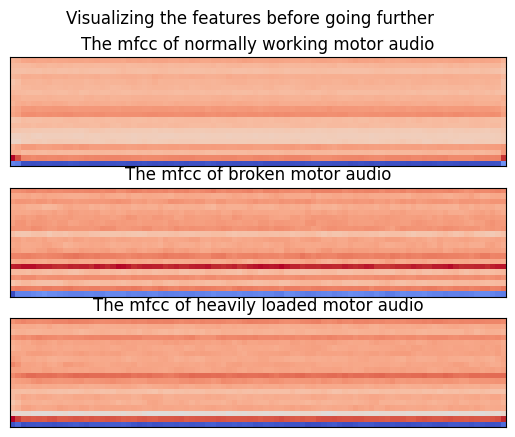

In [18]:
plt.subplot(3,1,1)
librosa.display.specshow(X_train[7])
plt.title("The mfcc of normally working motor audio")

plt.subplot(3,1,2)
librosa.display.specshow(X_train[5])
plt.title("The mfcc of broken motor audio")

plt.subplot(3,1,3)
librosa.display.specshow(X_train[9])
plt.title("The mfcc of heavily loaded motor audio")

plt.suptitle("Visualizing the features before going further")


In [19]:
X_train2 = []

for x in X_train:
  X_train2.append(x.flatten())

In [20]:
X_test2 = []

for x in X_test:
  X_test2.append(x.flatten())

In [21]:
X_train2[0].shape,X_test2[0].shape

((1880,), (1880,))

In [41]:
from sklearn.svm import SVC

classifier = SVC(kernel = "linear",gamma = "auto")

classifier.fit(X_train2, Y_train)

SVC(gamma='auto', kernel='linear')

In [50]:
import numpy as np
from sklearn.svm import SVC
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import tensorflow as tf

initial_type = [('float_input', FloatTensorType([None, X_train2.shape[1]]))]
onnx_model = convert_sklearn(classifier, initial_types=initial_type)

# Save the ONNX model to a file
onnx_path = "svm_model.onnx"
with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

# Step 2: Convert ONNX Model to TensorFlow Lite
loaded_onnx_model = tf.saved_model.load(onnx_path)

converter = tf.lite.TFLiteConverter.from_saved_model(loaded_onnx_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_path = "svm_model.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)


ModuleNotFoundError: ignored

In [42]:
y_pred = classifier.predict(X_test2)

In [34]:
accuracy = classifier.score(X_test2,Y_test)
print("accuracy:",accuracy)

accuracy: 0.9361702127659575


In [35]:
y_pred_mod = []
Y_test_mod = []

for i in range(len(Y_test)):
  if Y_test[i] == 2 or Y_test[i] == 3:
    Y_test_mod.append(-1)
  else:
    Y_test_mod.append(1)

for y in y_pred:
  if y == 2 or y == 3:
    y_pred_mod.append(-1)
  else:
    y_pred_mod.append(1)

In [36]:
c = 0

for i in range(len(Y_test)):
  if y_pred_mod[i] == Y_test_mod[i]:
    c = c + 1

accuracy3= (c/len(Y_test))

print("accuracy in this case:", accuracy3)

accuracy in this case: 0.9416130628401781


In [37]:
predicted_motor_condition = []

for y in y_pred:
  if y == 2 or y == 3:
    predicted_motor_condition.append("Anomaly_Detected")
  else:
    predicted_motor_condition.append("Motor is working normally")

In [38]:
true_motor_condition = []

for y in Y_test:
  if y == 2 or y == 3:
    true_motor_condition.append("Anomaly_Detected")
  else:
    true_motor_condition.append("Motor is working normally")

In [29]:
predicted_motor_condition

['Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Motor is working normally',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Motor is working normally',
 'Motor is working normally',
 'Motor is working normally',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Motor is working normally',
 'Motor is working normally',
 'Motor is working normally',
 'Motor is working normally',
 'Anomaly_Detected',
 'Motor is working normally',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Motor is working normally',
 'Anomaly_Detected',
 'Motor is working normally',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Motor is working normally',
 'Motor is working normally',
 'Motor is working normally',
 'Motor is working normally',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'An

In [ ]:
true_motor_condition

['Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Motor is working normally',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Motor is working normally',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Motor is working normally',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Motor is working normally',
 'Motor is working normally',
 'Motor is working normally',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Motor is working normally',
 'Anomaly_Detected',
 'Motor is working normally',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Motor is working normally',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detected',
 'Anomaly_Detect